Device: cuda
Dataset shapes: torch.Size([1000, 200, 1]) torch.Size([1000, 1])


C:\Users\arung\AppData\Local\Temp\ipykernel_33960\3447743821.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.tensor(X).float().unsqueeze(-1)


[RNN] Epoch 20/120 Loss: 0.000236 MeanGrad:1.127621e-03 MaxGrad:3.406468e-03
[RNN] Epoch 40/120 Loss: 0.000104 MeanGrad:1.886466e-03 MaxGrad:5.576030e-03
[RNN] Epoch 60/120 Loss: 0.000053 MeanGrad:7.130041e-04 MaxGrad:1.902378e-03
[RNN] Epoch 80/120 Loss: 0.000039 MeanGrad:9.815402e-04 MaxGrad:3.065531e-03
[RNN] Epoch 100/120 Loss: 0.000042 MeanGrad:1.237035e-03 MaxGrad:3.873639e-03
[RNN] Epoch 120/120 Loss: 0.000036 MeanGrad:8.054482e-04 MaxGrad:2.507470e-03
[LSTM] Epoch 20/120 Loss: 0.000472 MeanGrad:1.376492e-03 MaxGrad:6.253185e-03
[LSTM] Epoch 40/120 Loss: 0.000163 MeanGrad:2.019501e-03 MaxGrad:9.339169e-03
[LSTM] Epoch 60/120 Loss: 0.000070 MeanGrad:8.651299e-04 MaxGrad:3.766926e-03
[LSTM] Epoch 80/120 Loss: 0.000034 MeanGrad:6.035549e-04 MaxGrad:2.711145e-03
[LSTM] Epoch 100/120 Loss: 0.000042 MeanGrad:1.409234e-03 MaxGrad:6.561791e-03
[LSTM] Epoch 120/120 Loss: 0.000025 MeanGrad:7.511523e-04 MaxGrad:3.378588e-03
[GRU] Epoch 20/120 Loss: 0.000772 MeanGrad:2.808877e-03 MaxGrad:1.

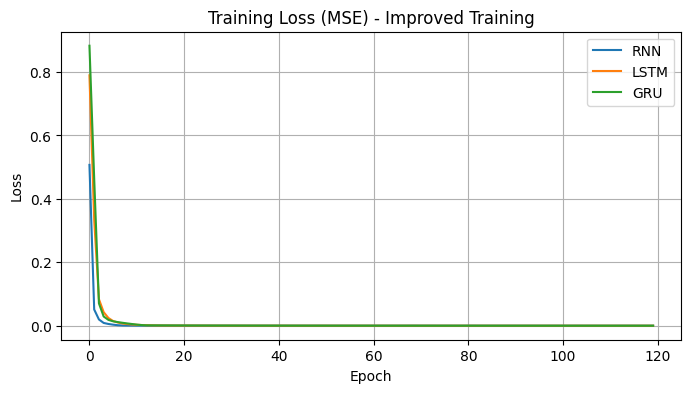

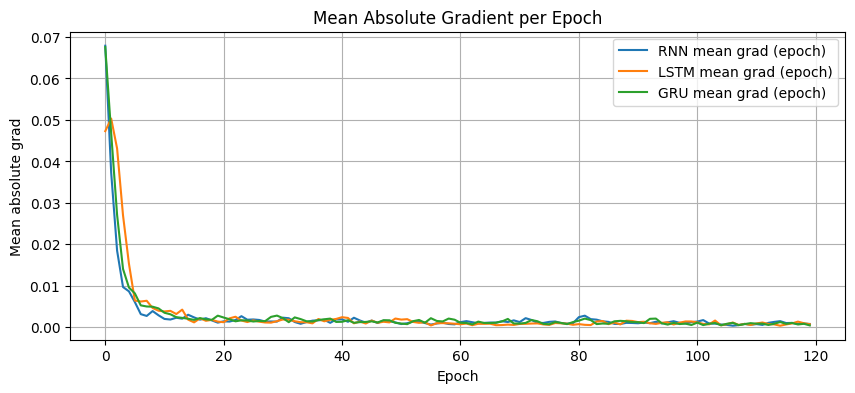

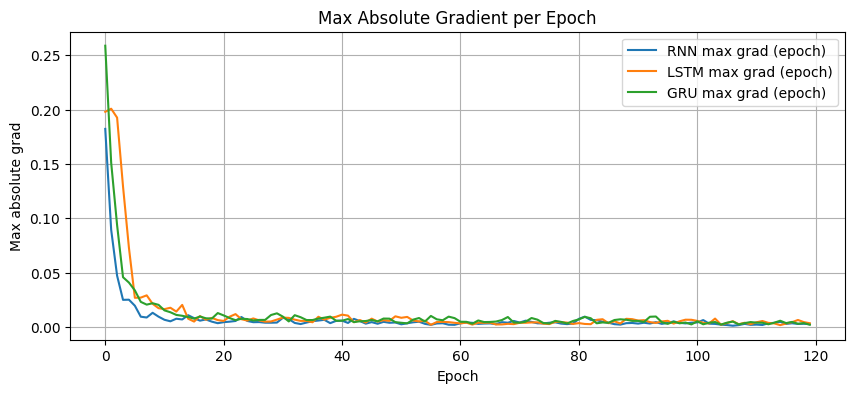

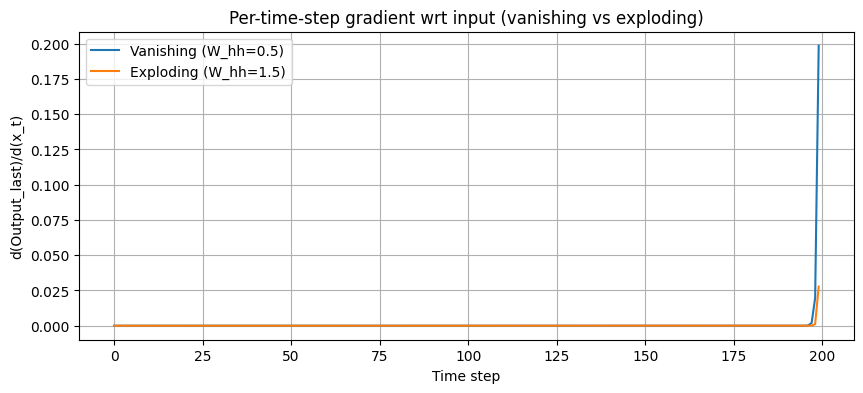

C:\Users\arung\AppData\Local\Temp\ipykernel_33960\3447743821.py:234: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new = torch.tensor(out).float().view(1,1,1).to(device)


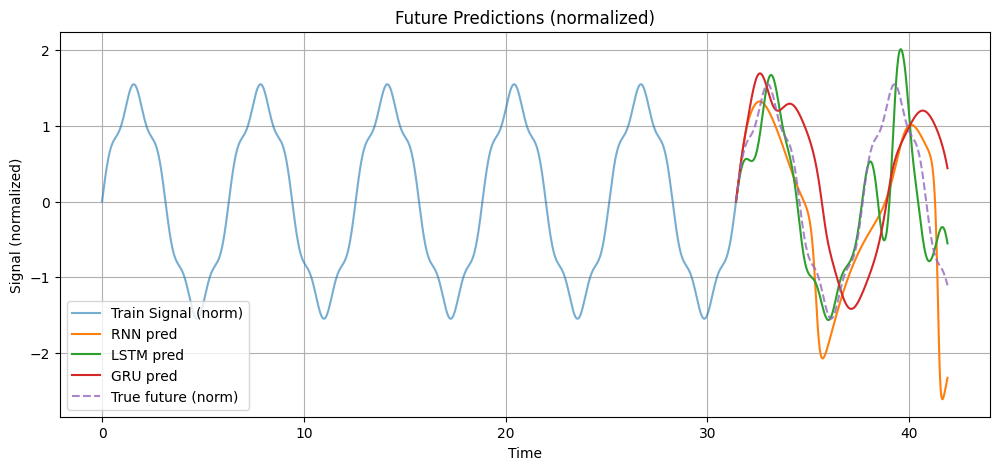

Final Losses (last epoch):
RNN:  0.000036
LSTM: 0.000025
GRU:  0.000024
\nNotes:
- Models trained with batch training, normalization, and fair hidden sizes.
- Per-time-step gradient plot clearly shows vanishing vs exploding for TinyRNN controlled W_hh.
- Gradient statistics (mean/max per epoch) indicate how gradients behave during training.


In [1]:

# Improved RNN vs LSTM vs GRU Notebook
# Includes: better training, normalization, batch training, fairer capacity,
# per-time-step gradient visualization (vanishing vs exploding), and combined prediction plots.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# Settings
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
np.random.seed(0)
print("Device:", device)

# -----------------------------
# 1) Dataset: normalized sine wave
# -----------------------------
T = 200           # input sequence length
L = 1200         # total points
L1=10*np.pi
time = np.linspace(0, L1, L)
data = np.sin(time) + 0.1 * np.sin(5*time)  # slightly richer signal

# normalize (zero mean, unit std) using training portion
mean = data.mean()
std = data.std()
data_norm = (data - mean) / std

def create_dataset(data, seq_len=T):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    X = torch.tensor(X).float().unsqueeze(-1)
    Y = torch.tensor(Y).float().unsqueeze(-1)
    return X, Y

X, Y = create_dataset(data_norm)
print("Dataset shapes:", X.shape, Y.shape)

# use DataLoader for batch training
batch_size = 64
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# select last sequence as seed for predictions (denormalize later)
last_seq = X[-1].squeeze(-1).cpu().numpy()

# -----------------------------
# 2) Model definitions (fair capacity)
# -----------------------------
hidden_size = 64

class RNNModel(nn.Module):
    def __init__(self, hidden=hidden_size):
        super().__init__()
        self.rnn = nn.RNN(1, hidden, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, hidden=hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, hidden=hidden_size):
        super().__init__()
        self.gru = nn.GRU(1, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# -----------------------------
# 3) Training loop that records gradient norms and per-parameter grad stats
# -----------------------------
def train_model(model, dataloader, epochs=120, lr=0.001, name="model"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []
    grad_means = []   # average gradient magnitude across params per epoch
    grad_maxs = []    # max gradient magnitude per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()
        batch_grad_means = []
        batch_grad_maxs = []
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()

            # collect gradient norms for analysis (per batch)
            grads = []
            for p in model.parameters():
                if p.grad is not None:
                    grads.append(p.grad.detach().abs().mean().cpu().item())
            if grads:
                batch_grad_means.append(float(np.mean(grads)))
                batch_grad_maxs.append(float(np.max(grads)))
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(dataloader.dataset)
        losses.append(epoch_loss)
        # aggregate batch stats to per-epoch stats
        grad_means.append(float(np.mean(batch_grad_means)) if batch_grad_means else 0.0)
        grad_maxs.append(float(np.mean(batch_grad_maxs)) if batch_grad_maxs else 0.0)
        if (epoch+1) % 20 == 0:
            print(f"[{name}] Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.6f} MeanGrad:{grad_means[-1]:.6e} MaxGrad:{grad_maxs[-1]:.6e}")
    return model, losses, grad_means, grad_maxs

# -----------------------------
# 4) Train RNN, LSTM, GRU
# -----------------------------
rnn = RNNModel()
lstm = LSTMModel()
gru = GRUModel()

rnn, loss_rnn, grad_mean_rnn, grad_max_rnn = train_model(rnn, dl, epochs=120, lr=0.001, name="RNN")
lstm, loss_lstm, grad_mean_lstm, grad_max_lstm = train_model(lstm, dl, epochs=120, lr=0.001, name="LSTM")
gru, loss_gru, grad_mean_gru, grad_max_gru = train_model(gru, dl, epochs=120, lr=0.001, name="GRU")

# -----------------------------
# 5) Plot training loss comparison
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(loss_rnn, label='RNN')
plt.plot(loss_lstm, label='LSTM')
plt.plot(loss_gru, label='GRU')
plt.title("Training Loss (MSE) - Improved Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 6) Plot gradient statistics (per-epoch)
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(grad_mean_rnn, label='RNN mean grad (epoch)')
plt.plot(grad_mean_lstm, label='LSTM mean grad (epoch)')
plt.plot(grad_mean_gru, label='GRU mean grad (epoch)')
plt.title("Mean Absolute Gradient per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute grad")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(grad_max_rnn, label='RNN max grad (epoch)')
plt.plot(grad_max_lstm, label='LSTM max grad (epoch)')
plt.plot(grad_max_gru, label='GRU max grad (epoch)')
plt.title("Max Absolute Gradient per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Max absolute grad")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7) Per-time-step gradient demonstration (Tiny RNN) for vanishing vs exploding
# -----------------------------
class TinyRNN(nn.Module):
    def __init__(self, W_hh_val=0.5):
        super().__init__()
        self.W_hh = nn.Parameter(torch.tensor([[W_hh_val]], dtype=torch.float32))
        self.W_xh = nn.Parameter(torch.tensor([[1.0]], dtype=torch.float32))
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = torch.zeros(1,1)
        hs = []
        for t in range(x.size(0)):
            h = self.tanh(self.W_hh @ h + self.W_xh @ x[t].unsqueeze(1))
            hs.append(h)
        hs = torch.stack(hs).squeeze(-1)
        return hs

seq_len = T
x = torch.ones(seq_len, 1, requires_grad=True)

tiny_v = TinyRNN(W_hh_val=0.5)
out_v = tiny_v(x)
loss_v = out_v[-1].sum()
loss_v.backward(retain_graph=True)
grads_v = x.grad.detach().numpy().flatten().copy()
x.grad.zero_()

x2 = torch.ones(seq_len, 1, requires_grad=True)
tiny_e = TinyRNN(W_hh_val=1.5)
out_e = tiny_e(x2)
loss_e = out_e[-1].sum()
loss_e.backward()
grads_e = x2.grad.detach().numpy().flatten().copy()

plt.figure(figsize=(10,4))
plt.plot(grads_v, label='Vanishing (W_hh=0.5)')
plt.plot(grads_e, label='Exploding (W_hh=1.5)')
plt.title("Per-time-step gradient wrt input (vanishing vs exploding)")
plt.xlabel("Time step")
plt.ylabel("d(Output_last)/d(x_t)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8) Prediction: generate future sequence and denormalize
# -----------------------------
def predict_future(model, seed_seq, steps=400):
    model.eval()
    seq = torch.tensor(seed_seq).float().unsqueeze(0).unsqueeze(-1).to(device)
    preds = []
    with torch.no_grad():
        for _ in range(steps):
            out = model(seq)
            preds.append(out.item())
            new = torch.tensor(out).float().view(1,1,1).to(device)
            seq = torch.cat((seq[:,1:,:], new), dim=1)
    return np.array(preds)

steps = 400
pred_rnn = predict_future(rnn, last_seq, steps)
pred_lstm = predict_future(lstm, last_seq, steps)
pred_gru = predict_future(gru, last_seq, steps)

t_future = np.linspace(time[-1], time[-1] + (steps*(time[1]-time[0])), steps)
true_future = np.sin(t_future) + 0.1*np.sin(5*t_future)
true_future_norm = (true_future - mean) / std

plt.figure(figsize=(12,5))
plt.plot(np.linspace(time[0], time[-1], len(data_norm)), data_norm, label='Train Signal (norm)', alpha=0.6)
plt.plot(t_future, pred_rnn, label='RNN pred')
plt.plot(t_future, pred_lstm, label='LSTM pred')
plt.plot(t_future, pred_gru, label='GRU pred')
plt.plot(t_future, true_future_norm, label='True future (norm)', linestyle='--', alpha=0.8)
plt.title("Future Predictions (normalized)")
plt.xlabel("Time")
plt.ylabel("Signal (normalized)")
plt.legend()
plt.grid(True)
plt.show()

print("Final Losses (last epoch):")
print(f"RNN:  {loss_rnn[-1]:.6f}")
print(f"LSTM: {loss_lstm[-1]:.6f}")
print(f"GRU:  {loss_gru[-1]:.6f}")

print('\\nNotes:')
print('- Models trained with batch training, normalization, and fair hidden sizes.')
print('- Per-time-step gradient plot clearly shows vanishing vs exploding for TinyRNN controlled W_hh.')
print('- Gradient statistics (mean/max per epoch) indicate how gradients behave during training.')
